In [15]:
import pyreadstat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, roc_auc_score, auc, confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

import torch
import torch.nn as nn
import torch.optim as optim

import importlib
import modular_model

# Reload the module
importlib.reload(modular_model)

# loading our deep neural network model which accounts for common coexpression modular structure
from modular_model import CombinedNetwork

In [3]:
# Loading the LLFS dataset
LLFS_df = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/LLFS part/LLFS_planB_data.csv')
LLFS_df.shape

(1302, 18163)

In [ ]:
# common coexpression modules from group lasso
common_modules = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/cpm3/common_modules.csv')

# finding overlapping genes
common_modules2 = common_modules.loc[common_modules['gene_id'].isin(LLFS_df.columns), :]
common_modules2['mod_color'].value_counts()

mod_color
blue     1066
brown     459
black     248
pink      193
Name: count, dtype: int64

In [ ]:
# reading the dataset with CMV significant genes
CMV_clonotypes_data = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/cpm3/final_dataset.csv')
CMV_clonotypes_data.shape

(3435, 4706)

In [6]:
# scaling and normalization
clipper = RobustScaler()
scaler = StandardScaler()

temp = clipper.fit_transform(CMV_clonotypes_data[common_modules2['gene_id']])
CMV_clonotypes_data[common_modules2['gene_id']] = scaler.fit_transform(temp)

In [7]:
# sklearn train-test split
train_set, test_set = train_test_split(CMV_clonotypes_data, test_size=0.4, random_state=42, stratify=CMV_clonotypes_data['mortality'])

print("Train set size:", train_set.shape[0])
print("Train set size:", test_set.shape[0])

X_train = train_set[common_modules2['gene_id']]
y_train = train_set[['mortality']]
X_test = test_set[common_modules2['gene_id']]
y_test = test_set[['mortality']]

Train set size: 2061
Train set size: 1374


### Neural-network module with modular structure

In [19]:
# Instantiating the model from the file modular_model.py
model = CombinedNetwork(input_dim1 = 1066, input_dim2 = 459, input_dim3 = 248, input_dim4 = 193)

# Input tensors
x1 =  torch.tensor(X_train[common_modules2['gene_id'][common_modules2['mod_color'] == "blue"]].to_numpy(), dtype=torch.float32)
x2 = torch.tensor(X_train[common_modules2['gene_id'][common_modules2['mod_color'] == "brown"]].to_numpy(), dtype=torch.float32)
x3 = torch.tensor(X_train[common_modules2['gene_id'][common_modules2['mod_color'] == "black"]].to_numpy(), dtype=torch.float32)
x4 = torch.tensor(X_train[common_modules2['gene_id'][common_modules2['mod_color'] == "pink"]].to_numpy(), dtype=torch.float32)

# Forward pass
output = model(x1, x2, x3, x4)

Epoch 0, Loss: 0.5802
Epoch 10, Loss: 0.4754
Epoch 20, Loss: 0.3846
Epoch 30, Loss: 0.3627
Epoch 40, Loss: 0.3305
Epoch 50, Loss: 0.3040
Epoch 60, Loss: 0.2779
Epoch 70, Loss: 0.2484
Epoch 80, Loss: 0.2090
Epoch 90, Loss: 0.1632
Epoch 100, Loss: 0.1206
Epoch 110, Loss: 0.0851
Epoch 120, Loss: 0.0573
Epoch 130, Loss: 0.0364
Epoch 140, Loss: 0.0231
Epoch 150, Loss: 0.0163
Epoch 160, Loss: 0.0134
Epoch 170, Loss: 0.0106
Epoch 180, Loss: 0.0065
Epoch 190, Loss: 0.0048
Epoch 200, Loss: 0.0042
Epoch 210, Loss: 0.0039
Epoch 220, Loss: 0.0037
Epoch 230, Loss: 0.0035
Epoch 240, Loss: 0.0034
Epoch 250, Loss: 0.0033
Epoch 260, Loss: 0.0033
Epoch 270, Loss: 0.0029
Epoch 280, Loss: 0.0027
Epoch 290, Loss: 0.0026
Epoch 300, Loss: 0.0026
Epoch 310, Loss: 0.0025
Epoch 320, Loss: 0.0024
Epoch 330, Loss: 0.0020
Epoch 340, Loss: 0.0020
Epoch 350, Loss: 0.0019
Epoch 360, Loss: 0.0019
Epoch 370, Loss: 0.0019
Epoch 380, Loss: 0.0019
Epoch 390, Loss: 0.0019
Epoch 400, Loss: 0.0018
Epoch 410, Loss: 0.0018
Epo

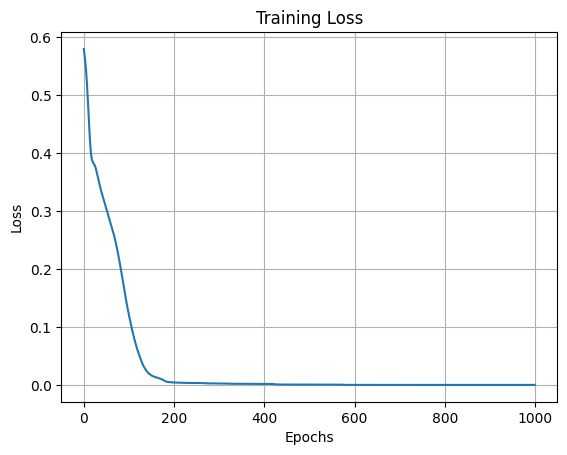

In [20]:
# Loss Function and optimizer
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(x1, x2, x3, x4)
    
    # Compute loss
    loss = criterion(output[0], torch.tensor(y_train.to_numpy()).float())
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
# Plot loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

In [37]:
### Saving the model checkpoint
torch.save(model.state_dict(), 'HRS_LLFS_overlap_mod.pt')

In [21]:
train_set['blue_mod'] = output[1].detach().numpy()
train_set['brown_mod'] = output[2].detach().numpy()
train_set['black_mod'] = output[3].detach().numpy()
train_set['pink_mod'] = output[4].detach().numpy()

/tmp/ipykernel_155812/3691260167.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['blue_mod'] = output[1].detach().numpy()
/tmp/ipykernel_155812/3691260167.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['brown_mod'] = output[2].detach().numpy()
/tmp/ipykernel_155812/3691260167.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

### Model Evaluation

In [23]:
# Input tensors
x1_test =  torch.tensor(X_test[common_modules2['gene_id'][common_modules2['mod_color'] == "blue"]].to_numpy(), dtype=torch.float32)
x2_test =  torch.tensor(X_test[common_modules2['gene_id'][common_modules2['mod_color'] == "brown"]].to_numpy(), dtype=torch.float32)
x3_test = torch.tensor(X_test[common_modules2['gene_id'][common_modules2['mod_color'] == "black"]].to_numpy(), dtype=torch.float32)
x4_test = torch.tensor(X_test[common_modules2['gene_id'][common_modules2['mod_color'] == "pink"]].to_numpy(), dtype=torch.float32)

In [6]:
# loading the model and the trained weights
# model = CombinedNetwork(input_dim1 = 1066, input_dim2 = 459, input_dim3 = 248, input_dim4 = 193)
# model.load_state_dict(torch.load('HRS_LLFS_overlap_mod.pt'))

<All keys matched successfully>

In [24]:
# setting the model in evaluation mode
model.eval()

# Make predictions on the validation set
with torch.no_grad():
    outputs = model(x1_test, x2_test, x3_test, x4_test)
    predictions = (torch.sigmoid(outputs[0]) > 0.5).float()  # Convert logits to binary predictions (0 or 1)

# Convert predictions and true labels to numpy arrays
pred_np = predictions.reshape(1, -1).numpy()[0]  # Flatten predictions to a 1D array
labels_np = np.array(y_test)

In [25]:
# classification report on the validation dataset
print(classification_report(labels_np, pred_np, target_names=['alive', 'dead']))

              precision    recall  f1-score   support

       alive       0.91      0.96      0.93      1220
        dead       0.39      0.22      0.28       154

    accuracy                           0.87      1374
   macro avg       0.65      0.59      0.61      1374
weighted avg       0.85      0.87      0.86      1374



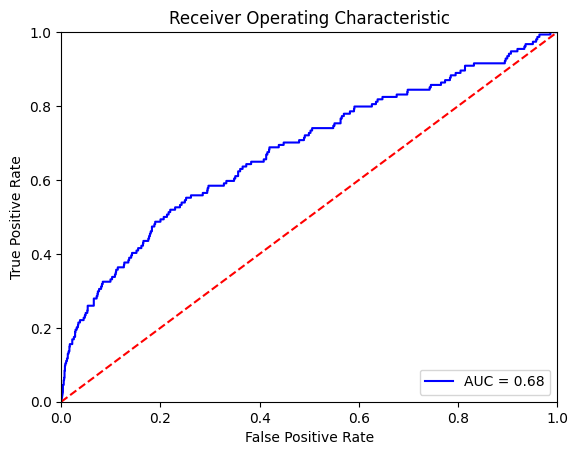

In [26]:
# ROC curve using sigmoid probabilities calculated from genetic scores in the test dataset
fpr, tpr, threshold = roc_curve(y_test, torch.sigmoid(outputs[0]))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

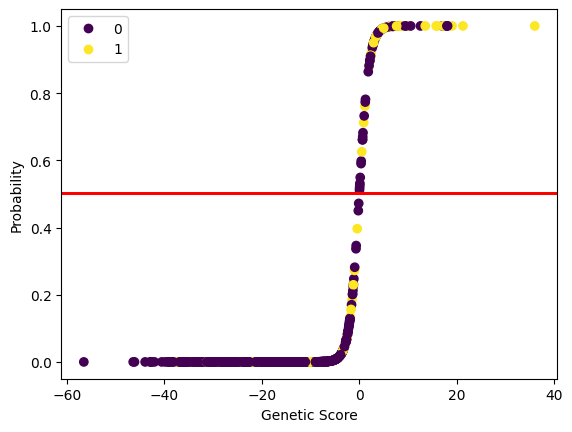

In [27]:
# classification scatterplot
indep, dep = outputs[0].numpy(), torch.sigmoid(outputs[0]).numpy()
fig, ax = plt.subplots()
scatter = ax.scatter(indep, dep, c=labels_np)
line = mlines.Line2D(indep, [0.5]*len(dep), color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.legend(*scatter.legend_elements())
plt.xlabel("Genetic Score")
plt.ylabel("Probability")
plt.show()

In [28]:
test_set['blue_mod'] = outputs[1]
test_set['brown_mod'] = outputs[2]
test_set['black_mod'] = outputs[3]
test_set['pink_mod'] = outputs[4]

/tmp/ipykernel_155812/1647090890.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['blue_mod'] = outputs[1]
/tmp/ipykernel_155812/1647090890.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['brown_mod'] = outputs[2]
/tmp/ipykernel_155812/1647090890.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

### Evaluating associations of modules with mortality in the HRS test set

In [29]:
# transforming the covariates
temp = clipper.fit_transform(test_set[['age', 'INFLAM_5', 'comorb_idx', 'BMI', 'Tcells']])
test_set[['age', 'INFLAM_5', 'comorb_idx', 'BMI', 'Tcells']] = scaler.fit_transform(temp)

In [33]:
temp = clipper.fit_transform(test_set[['blue_mod', 'brown_mod', 'black_mod', 'pink_mod']])
test_set[['blue_mod', 'brown_mod', 'black_mod', 'pink_mod']] = scaler.fit_transform(temp)

In [30]:
# factor conversions
test_set['sex'] = test_set['sex'].astype('category')

test_set['race'] = test_set['race'].astype('category')
test_set['race'] = test_set['race'].cat.set_categories(['Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Non-Hispanic Other'], ordered=True)

test_set['CMV_status'] = test_set['CMV_status'].astype('category')
test_set['CMV_status'] = test_set['CMV_status'].cat.set_categories(['Negative', 'Positive'], ordered=True)

In [39]:
# Define GLM model using formula notation
glm_model = smf.glm("mortality ~ blue_mod + brown_mod + black_mod + pink_mod", data=test_set, family=sm.families.Binomial()).fit()

# Extract odds ratios, confidence intervals, and p-values
odds_ratios = pd.DataFrame({
    'Odds Ratio': np.exp(glm_model.params),  # Convert log-odds to odds ratios
    'Lower CI': np.exp(glm_model.conf_int()[0]),  # Lower bound of 95% CI
    'Upper CI': np.exp(glm_model.conf_int()[1]),  # Upper bound of 95% CI
    'P-value': glm_model.pvalues
}).round(4)

# Display results
print(odds_ratios)

           Odds Ratio  Lower CI  Upper CI  P-value
Intercept      0.1035    0.0852    0.1257   0.0000
blue_mod       0.5275    0.4325    0.6435   0.0000
brown_mod      1.7427    1.4775    2.0556   0.0000
black_mod      0.8253    0.6620    1.0289   0.0879
pink_mod       0.8390    0.7038    1.0002   0.0502
